In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6'
import torch

import json
from pathlib import Path
from transformers import T5ForConditionalGeneration
from collections import defaultdict

from src.utils.tokenizer import BpeTokenizer
# from helpers import preprocess_rna


In [3]:
# Device setup
device = 'cuda' if torch.cuda.is_available else 'cpu'
    
# Load the T5 model
model_path = "/data6/sobhan/RLLM/finetune/checkpoint-370200"
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
model.config.output_attentions = True
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(1000, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(1000, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=768, bias=False)
              (k): Linear(in_features=512, out_features=768, bias=False)
              (v): Linear(in_features=512, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=1024, bias=False)
              (wo): Linear(in_features=1024, out_features=512, bias=False)
              (dropout): Dropo

In [4]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

class InteractionDataset(Dataset):
    def __init__(self, file_path):
        with open(file_path, 'r') as f:
            self.data = [line.strip() for line in f if line.strip()][:1000]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        line = self.data[idx]
        try:
            protein_seq, rna_seq = line.split('$')
        except ValueError:
            raise ValueError(f"Line {idx} in dataset is not in the expected PROTEIN$RNA format.")
        return protein_seq, rna_seq

In [5]:
positive_dataset = InteractionDataset("/data6/sobhan/dataset/prediction/ELAVL1_positives.txt")


In [6]:
def preprocess_rna(rna):
    return rna.lower().replace(
                    'a', 'B').replace('c', 'J').replace('u', 'U').replace('g', 'Z')


rna_tokenizer = BpeTokenizer(vocab_size=1000, seq_size=1024)
rna_tokenizer.load("/data6/sobhan/RLLM/dataset/tokenizers/bpe_rna_1000_1024.json")

protein_tokenizer = BpeTokenizer(vocab_size=1000, seq_size=1024)
protein_tokenizer.load("/data6/sobhan/RLLM/dataset/tokenizers/bpe_protein_1000_1024.json")



enable_padding(max_length=X) is deprecated, use enable_padding(length=X) instead
enable_padding(max_length=X) is deprecated, use enable_padding(length=X) instead


In [7]:
domains = [[20, 98], [106, 186], [244, 322]] # ELAVL1
# domains = [[12,90], [113,196]] # SRSF1
# domains = [[392, 817]] #AGO2
# domains = [[734, 939], [291, 357], [498, 733]] # MOV10
# domains = [[98, 178], [231, 315]] # RBM5

In [8]:
import numpy as np
n_samples = 0
head_scores_list = None  # will be a list of arrays, one per head

# Loop over your dataset
for protein_sequence, rna_sequence in positive_dataset:
    # Tokenize the sequences
    input_ids = protein_tokenizer.tokenize(protein_sequence)
    inputs = torch.tensor(input_ids.ids, dtype=torch.long).to(device)
    inputs = inputs.unsqueeze(0)  # shape: [1, seq_len]

    output_ids = rna_tokenizer.tokenize(rna_sequence)
    output = torch.tensor(output_ids.ids, dtype=torch.long).to(device)
    output = output.unsqueeze(0)  # shape: [1, seq_len]

    # Run model forward pass to obtain cross-attentions
    with torch.no_grad():
        outputs = model(
            input_ids=inputs,
            decoder_input_ids=output,
            output_attentions=True,
            return_dict=True
        )
    
    # Get cross-attentions from decoder: a tuple with one tensor per decoder layer.
    # We'll use the last layer.
    cross_attentions = outputs.cross_attentions
    last_layer_attn = cross_attentions[-1][0]  # shape: [num_heads, target_seq_len, source_seq_len]

    # For each head, average over decoder positions (target tokens) to get a per–encoder token score.
    num_heads = last_layer_attn.shape[0]
    sample_head_scores = []
    for h in range(num_heads):
        # head_attn: shape [target_seq_len, source_seq_len]
        head_attn = last_layer_attn[h]
        # Aggregate over decoder positions (e.g., take the mean)
        head_score, _ = head_attn.max(dim=0)  # shape: [source_seq_len]
        sample_head_scores.append(head_score.cpu().numpy())
    
    # Initialize accumulator on the first sample
    if head_scores_list is None:
        head_scores_list = [np.zeros_like(score) for score in sample_head_scores]
    # Accumulate scores for each head
    for h in range(num_heads):
        head_scores_list[h] += sample_head_scores[h]
    n_samples += 1

# Average over all samples for each head
head_scores_avg = [score / n_samples for score in head_scores_list]

# --------------------------
# Map Token Scores to Amino Acids
# --------------------------
# Build id-to-token mapping using the protein tokenizer JSON.
with open("/data6/sobhan/RLLM/dataset/tokenizers/bpe_protein_1000_1024.json", "r") as f:
    protein_tokenizer_data = json.load(f)
# Depending on your JSON structure, the vocab might be under "vocab" or "model"/"vocab".
# Adjust accordingly; here we try "model" first and then fallback to the top level.
if "model" in protein_tokenizer_data and "vocab" in protein_tokenizer_data["model"]:
    vocab = protein_tokenizer_data["model"]["vocab"]
else:
    vocab = protein_tokenizer_data["vocab"]
id_to_token = {v: k for k, v in vocab.items()}

# We'll use the tokens from one sample to decode the protein.
# (Assuming all sequences have the same tokenization; if not, choose a representative sample.)
decoded_tokens = [id_to_token.get(token_id, "<unk>") for token_id in input_ids.ids]

decoded_protein = "".join(decoded_tokens)
print("Decoded protein sequence:", decoded_protein)

# Define special tokens to ignore.
special_tokens = {"<pad>", "</s>", "<unk>"}

# Expand token-level scores to amino acid–level scores.
# We compute one expanded sequence (which is the same for every head) and for each head a list of per–amino acid scores.
expanded_sequence = []
expanded_scores_per_head = []  # list of lists; one per head

# For each token, if it is not a special token, distribute its score evenly across its letters.
for token in decoded_tokens:
    if token in special_tokens:
        continue
    for aa in token:
        expanded_sequence.append(aa)

# For each head, expand the token scores.
for head_idx, head_token_scores in enumerate(head_scores_avg):
    expanded_scores = []
    token_idx = 0
    # Loop over tokens in decoded_tokens and distribute score if not a special token.
    for token in decoded_tokens:
        if token in special_tokens:
            token_idx += 1
            continue
        token_score = head_token_scores[token_idx]
        # Distribute the token's score evenly among its amino acids.
        for aa in token:
            expanded_scores.append(token_score / len(token))
        token_idx += 1
    expanded_scores_per_head.append(expanded_scores)


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Decoded protein sequence: msngyedhmaedcrgdigrtnlivnylpqnmtqdelrslfssigevesaklirdkvaghslgygfvnyvtakdaeraintlnglrlqsktikvsyarpssevikdanlyisglprtmtqkdvedmfsrfgriinsrvlvdqttglsrgvafirfdkrseaeeaitsfnghkppgssepitvkfaanpnqnknvallsqlyhsparrfggpvhhqaqrfrfspmgvdhmsglsgvnvpgnassgwcifiynlgqdadegilwqmfgpfgavtnvkvirdfntnkckgfgfvtmtnyeeaamaiaslngyrlgdkilqvsfktnkshk</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

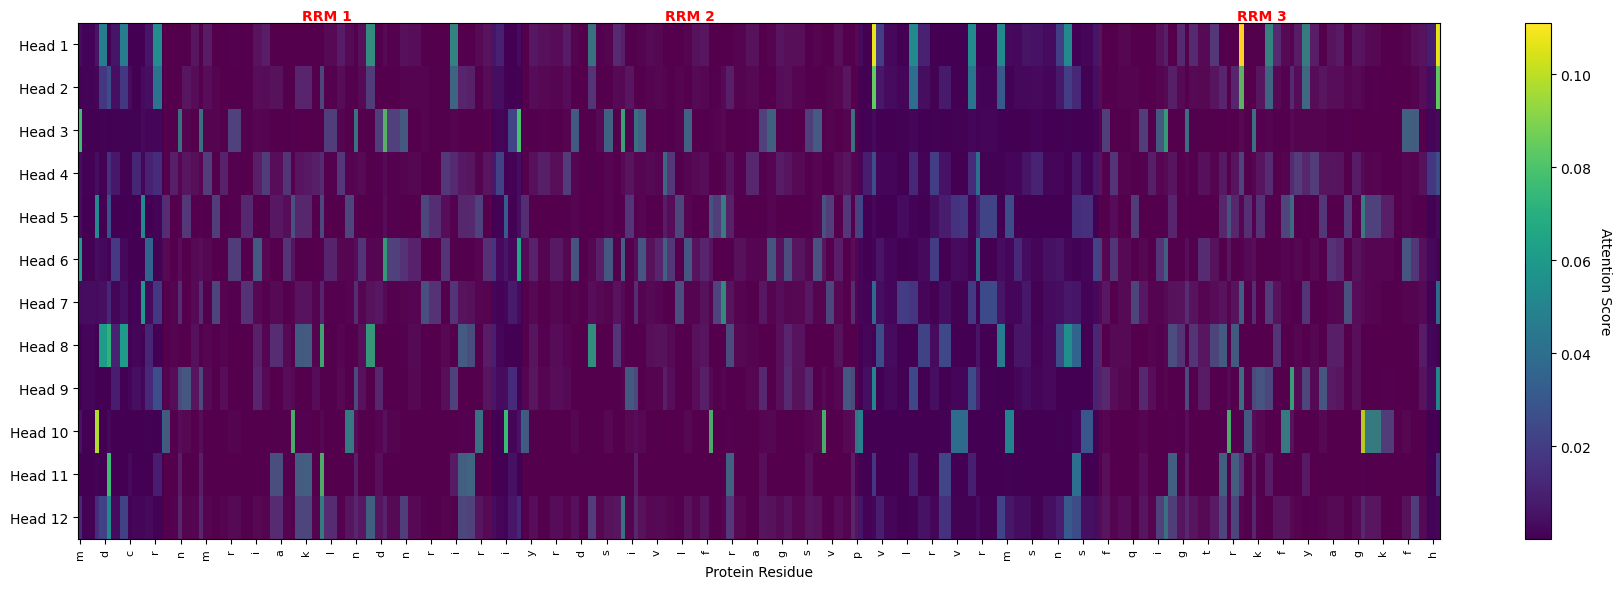

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the list of scores into a 2D NumPy array where each row corresponds to a head.
data = np.array(expanded_scores_per_head)  # shape: (num_heads, sequence_length)

fig, ax = plt.subplots(figsize=(18, 6))
im = ax.imshow(data, aspect='auto', cmap='viridis')

# Add a colorbar with a rotated label for clarity.
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Attention Score", rotation=270, labelpad=15)

# Label the y-axis with head numbers.
num_heads = data.shape[0]
ax.set_yticks(range(num_heads))
ax.set_yticklabels([f"Head {i+1}" for i in range(num_heads)])

# Dynamically adjust x-axis ticks based on protein length.
protein_length = len(expanded_sequence)
if protein_length > 50:
    step = max(1, protein_length // 50)
    tick_positions = list(range(0, protein_length, step))
    tick_labels = [expanded_sequence[i] for i in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=90, fontsize=8)
else:
    ax.set_xticks(range(protein_length))
    ax.set_xticklabels(expanded_sequence, rotation=90, fontsize=8)

ax.set_xlabel("Protein Residue")
# ax.set_title("Attention Scores Heatmap Across Heads")

# Overlay binding domains with shaded areas (reduced opacity) and add domain labels.
for idx, domain in enumerate(domains):
    start, end = domain
    ax.axvspan(start, end, color='red', alpha=0.09)
    # Annotate the domain by placing a label at the midpoint above the heatmap.
    mid = (start + end) / 2
    ax.text(mid, -0.5, f"RRM {idx+1}", color='red', ha='center',
            va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

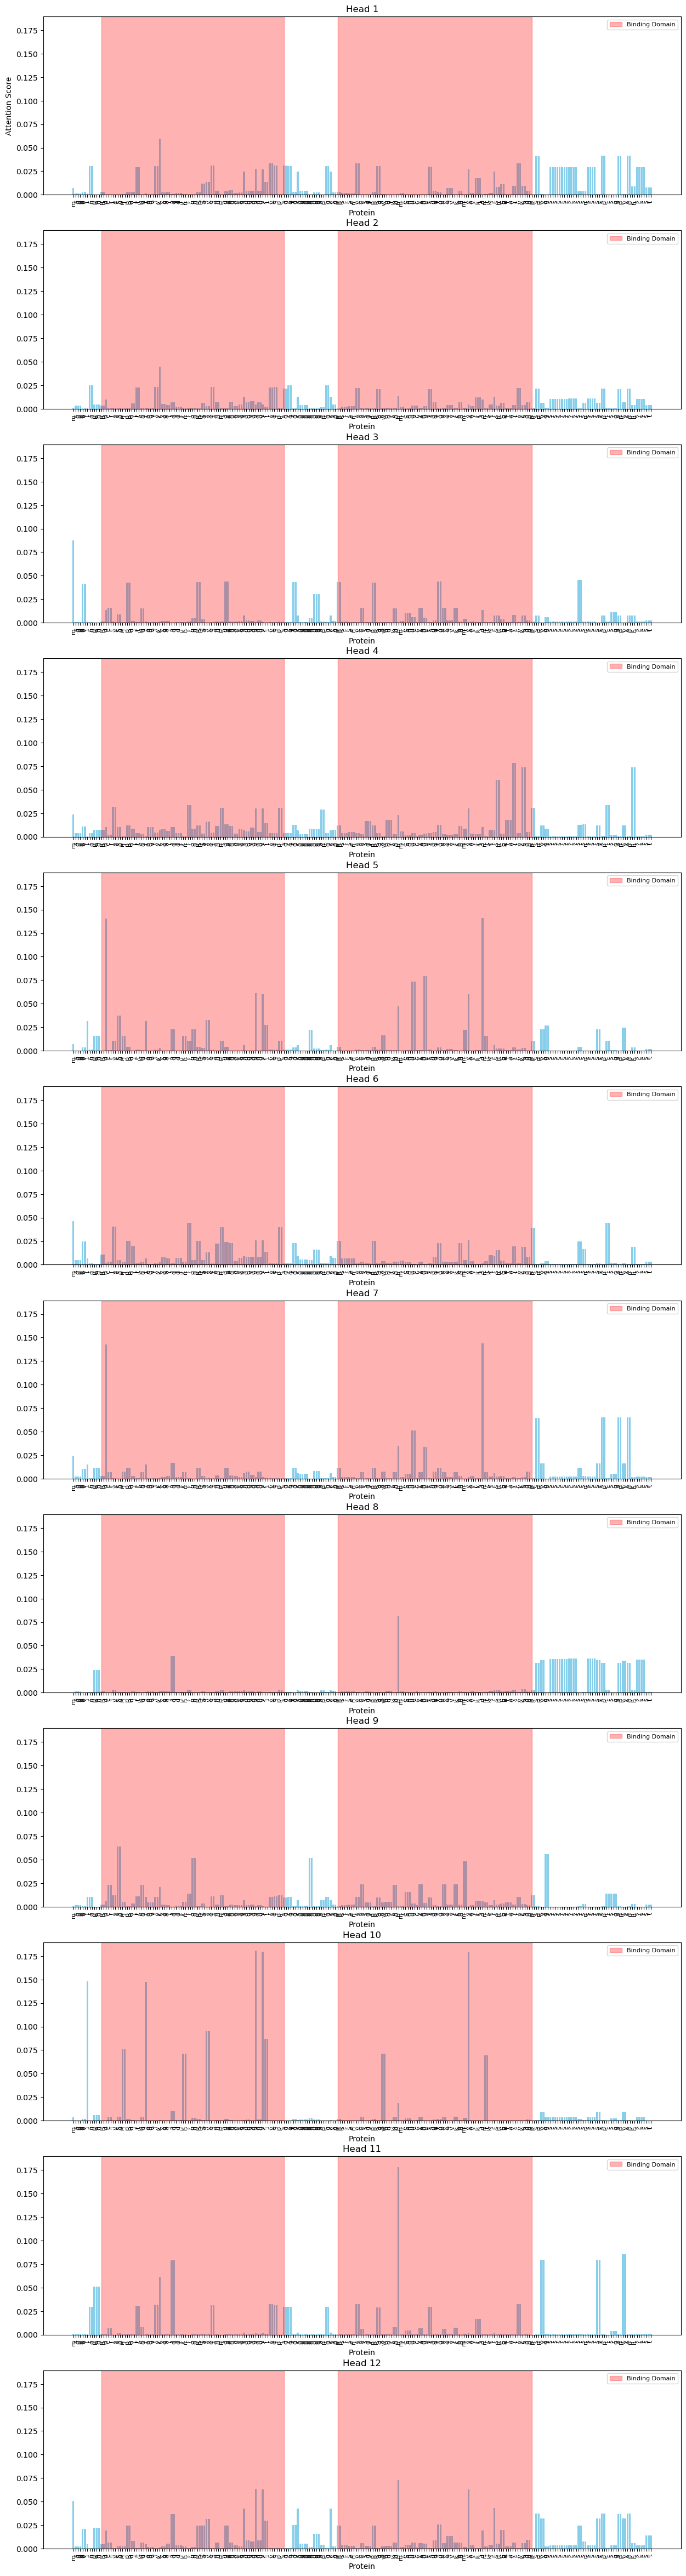

In [25]:
import matplotlib.pyplot as plt
num_heads = len(expanded_scores_per_head)
fig, axs = plt.subplots(num_heads, 1, figsize=(15, num_heads * 5), sharey=True)
if num_heads == 1:
    axs = [axs]  # ensure axs is iterable

positions = list(range(len(expanded_sequence)))
for h in range(num_heads):
    ax = axs[h]
    ax.bar(positions, expanded_scores_per_head[h], align='center', color='skyblue')
    ax.set_xticks(positions)
    ax.set_xticklabels(expanded_sequence, rotation=90, fontsize=8)
    ax.set_xlabel("Protein")
    ax.set_title(f"Head {h+1}")
    # Overlay the binding domains as shaded areas.
    for idx, domain in enumerate(domains):
        start, end = domain
        label = "Binding Domain" if idx == 0 else None
        ax.axvspan(start, end, color='red', alpha=0.3, label=label)
    ax.legend(loc='upper right', fontsize=8)

axs[0].set_ylabel("Attention Score")
plt.show()

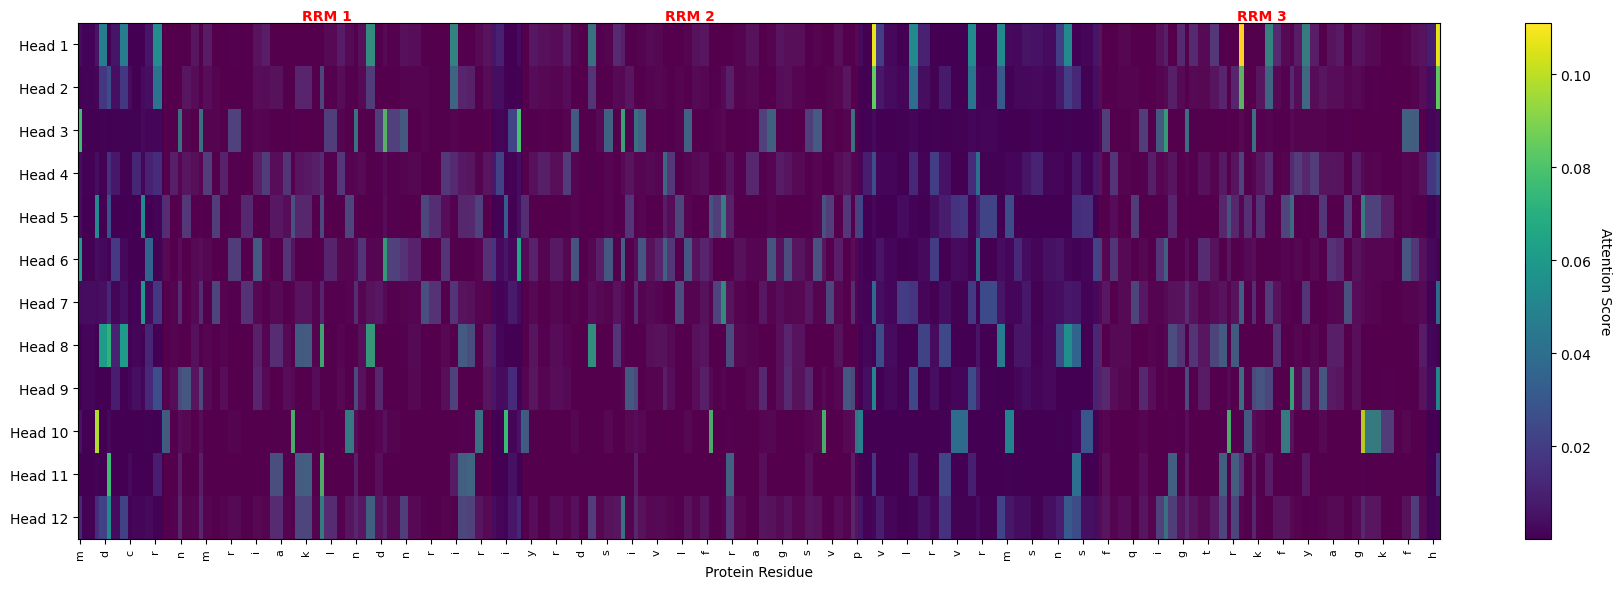

In [31]:
protein_sequence

'MSGGGVIRGPAGNNDCRIYVGNLPPDIRTKDIEDVFYKYGAIRDIDLKNRRGGPPFAFVEFEDPRDAEDAVYGRDGYDYDGYRLRVEFPRSGRGTGRGGGGGGGGGAPRGRYGPPSRRSENRVVVSGLPPSGSWQDLKDHMREAGDVCYADVYRDGTGVVEFVRKEDMTYAVRKLDNTKFRSHEGETAYIRVKVDGPRSPSYGRSRSRSRSRSRSRSRSNSRSRSYSPRRSRGSPRYSPRHSRSRSRT'

# Encoder

In [102]:
scores = []
for protein_sequence, rna_sequence in positive_dataset:
    # Tokenize the sequences
    input_ids = protein_tokenizer.tokenize(protein_sequence)
    inputs = torch.tensor(input_ids.ids, dtype=torch.long).to(device)
    inputs = inputs.unsqueeze(0)

    output_ids = rna_tokenizer.tokenize(rna_sequence)
    output = torch.tensor(output_ids.ids, dtype=torch.long).to(device)
    output = output.unsqueeze(0)

    with torch.no_grad():
        outputs = model.encoder(inputs, output_attentions=True, return_dict=True)
    
    encoder_attentions = outputs.attentions

    # To compute the "received" attention for each token, we average over heads and then average over the query positions.
    # This yields a score for each encoder token (the key positions).
    attn_received = torch.zeros(inputs.size(1)).to(device)
    num_layers = len(encoder_attentions)
    for layer_attn in encoder_attentions:
        # Select the first (and only) sample: shape [num_heads, seq_len, seq_len]
        layer_attn_sample = layer_attn[0]
        # Average over heads -> shape: [seq_len, seq_len]
        avg_over_heads, _ = layer_attn_sample.min(dim=0)
        # Now, average over the query dimension (dim=0) to see how much each token is attended to overall.
        attn_received_layer, _ = avg_over_heads.min(dim=0)
        attn_received += attn_received_layer

    # Final attention received score per encoder token
    final_encoder_scores = attn_received / num_layers
    scores.append(final_encoder_scores.cpu().numpy())


In [103]:
import numpy as np
final_attention_scores = np.array(scores).mean(axis=0)

Decoded protein sequence: mgsdkrvsrtersgrygsiidrddrderesrsrrrdsdykrssddrrgdryddyrdydsperererrnsdrsedgyhsdgdygehdyrhdisderesktimlrglpititesdiremmesfegpqpadvrlmkrktgvsrgfafvefyhlqdatswmeanqkklviqgkhiamhysnprpkfedwlcnkcclnnfrkrlkcfrcgadkfdseqevppgttesvqsvdyycdtiilrniaphtvvdsimtalspyaslavnnirlikdkqtqqnrgfafvqlssamdasqllqilqslhpplkidgktigvdfaksarkdlvlsdgnrvsafsvastaiaaaqwsstqsqsgeggsvdysylqpgqdgyaqyaqysqdyqqfyqqqagglesdassasgtavtttsaavvsqspqlynqtsnppgspteeaqpstststqapaasptgvvpgtkyavpdtstyqydessgyyydpttglyydpnsqyyynsltqqylywdgeketyvpaaessshqqsglppakegkekkekpksktaqqiakdmerwakslnkqkenfknsfqpvnslreeerresaaadagfalfekkgalaerqqlipelvrngdeenplkrglvaaysgdsdneeelverleseeekladwkkmacllcrrqfpnkdalvrhqqlsdlhkqnmdiyrrsrlseqelealelreremkyrdraaerrekygipeppepkrkkqfdagtvnyeqptkdgidhsnignkmlqamgwregsglgrkcqgitapieaqvrlkgaglgakgsayglsgadsykdavrkamfarfteme</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

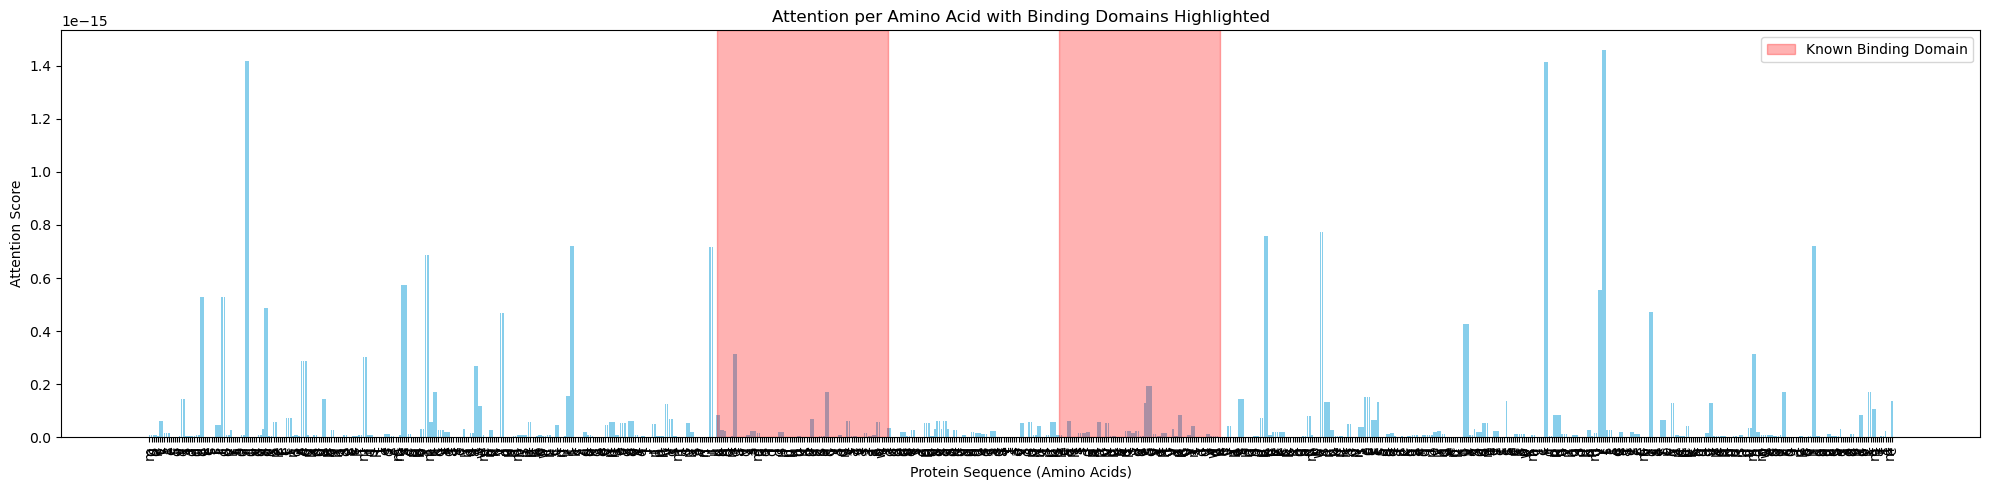

In [104]:
# --- Mapping attention scores to amino acids (per position) ---
import matplotlib.pyplot as plt
# Read the protein tokenizer vocabulary from the JSON to build an id-to-token mapping
with open("/data6/sobhan/RLLM/dataset/tokenizers/bpe_protein_1000_1024.json", "r") as f:
    protein_tokenizer_data = json.load(f)
vocab = protein_tokenizer_data["model"]["vocab"]
id_to_token = {v: k for k, v in vocab.items()}

# Decode the protein tokens: each token may represent one or more amino acids.
decoded_tokens = [id_to_token.get(token_id, "<unk>") for token_id in input_ids.ids]

decoded_protein = "".join(decoded_tokens)
print("Decoded protein sequence:", decoded_protein)

# Pair each token with its corresponding attention score (from the aggregated cross-attention)
token_attention_scores = list(zip(decoded_tokens, final_attention_scores))

# Define special tokens to ignore (e.g., padding and end-of-sequence tokens)
special_tokens = {"<pad>", "</s>", "<unk>"}

# Expand the token-level scores to individual amino acids by distributing each token's score evenly,
# ignoring any tokens that are in the special_tokens set.
expanded_sequence = []   # will hold each amino acid in order
expanded_scores = []     # will hold the corresponding distributed score for each position
for token, score in token_attention_scores:
    if token in special_tokens:
        continue  # skip special tokens
    for aa in token:
        expanded_sequence.append(aa)
        expanded_scores.append(score / len(token))


# Example binding domain regions (positions are 0-indexed)
# If your domains are 1-indexed, adjust accordingly.
domains = [[265, 345], [425, 500]]

plt.figure(figsize=(20, 5))
positions = list(range(len(expanded_sequence)))
plt.bar(positions, expanded_scores, align='center', color='skyblue')

# Set x-axis ticks to display the amino acids from the protein sequence.
plt.xticks(positions, expanded_sequence, rotation=90)
plt.xlabel("Protein Sequence (Amino Acids)")
plt.ylabel("Attention Score")
plt.title("Attention per Amino Acid with Binding Domains Highlighted")

# Overlay the binding domains as shaded areas
for idx, domain in enumerate(domains):
    start, end = domain
    # plt.axvspan expects x positions; adjust if your indexing differs.
    # Only label the first domain to avoid duplicate legend entries.
    label = "Known Binding Domain" if idx == 0 else None
    plt.axvspan(start, end, color='red', alpha=0.3, label=label)

plt.tight_layout()
plt.legend()
plt.show()

In [105]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu

# Create a set of indices that fall within any of the binding domains
binding_indices = set()
for start, end in domains:
    # Assuming start and end are inclusive and 0-indexed:
    binding_indices.update(range(start, end + 1))

# Split the attention scores into binding and non-binding groups based on their index positions.
binding_scores = [score for i, score in enumerate(expanded_scores) if i in binding_indices]
non_binding_scores = [score for i, score in enumerate(expanded_scores) if i not in binding_indices]

# Convert lists to numpy arrays for analysis
binding_scores = np.array(binding_scores)
non_binding_scores = np.array(non_binding_scores)

# Perform an independent t-test
t_stat, p_value_t = ttest_ind(binding_scores, non_binding_scores, equal_var=False)
print("T-test results: t-statistic = {:.4f}, p-value = {:.4f}".format(t_stat, p_value_t))

# Perform a Mann-Whitney U test (non-parametric)
u_stat, p_value_mw = mannwhitneyu(binding_scores, non_binding_scores, alternative="two-sided")
print("Mann-Whitney U test: U-statistic = {:.4f}, p-value = {:.4f}".format(u_stat, p_value_mw))


T-test results: t-statistic = -4.8352, p-value = 0.0000
Mann-Whitney U test: U-statistic = 48160.5000, p-value = 0.1877
